# Graph contraction - exact method

In [1]:
import sys
sys.path.insert(0,"../python")
import mcnf_ai
from mcnf_ai.mcnf import MCNF
from mcnf_ai.path import Path

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

First let's define a simple MCNF instance

In [3]:
# simple graph
G = nx.MultiDiGraph()
G.add_edge(1,2,cost=1,capacity=100)
G.add_edge(1,4,cost=1,capacity=100)
G.add_edge(2,3,cost=1,capacity=100)
G.add_edge(4,3,cost=1,capacity=100)
# demands
demands = np.array([[1,3,150]])
# instance 
instance = mcnf_ai.mcnf.MCNF(G, demands)

View the instance

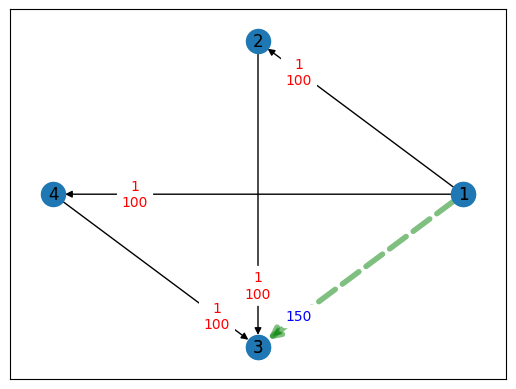

In [4]:
instance.draw(capacity_name="capacity")
plt.show()

Solve the instance

In [5]:
status, solution, solve_t = instance.solve_with_cplex()
print("Solve status : ", status)
print("Solution : ", solution)

Solve status :  optimal
Solution :  [100.  50. 100.  50.]


Get paths used for each demand

In [6]:
paths, flows = instance.solution_paths(solution)
for k, demand in enumerate(demands):
    print("Demand ", k, demand)
    for path, flow in zip(paths[k], flows[k]):
        print("\t", path, flow)

Demand  0 [  1   3 150]
	 Path ([(1, 2, 0), (2, 3, 0)]) 100.0
	 Path ([(1, 4, 0), (4, 3, 0)]) 50.0


View the solution

(<Figure size 640x480 with 1 Axes>,
 [<AxesSubplot:title={'center':'Demand 0: 1->3, d_0=150'}>])

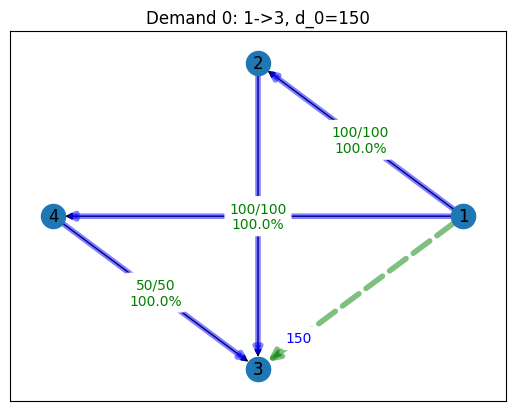

In [7]:
instance.draw_solution(solution)

## Example with contraction of the graph

In [8]:
# simple graph
G = nx.MultiDiGraph()
G.add_edge(5,4,cost=1,bandwidth=200)
G.add_edge(4,3,cost=1,bandwidth=100)
G.add_edge(3,2,cost=1,bandwidth=100)
G.add_edge(4,2,cost=1,bandwidth=100)
G.add_edge(2,1,cost=1,bandwidth=200)
G.add_edge(4,5,cost=1,bandwidth=200)
G.add_edge(3,4,cost=1,bandwidth=100)
G.add_edge(2,3,cost=1,bandwidth=100)
G.add_edge(2,4,cost=1,bandwidth=100)
G.add_edge(1,2,cost=1,bandwidth=200)
# demands
demands = np.array([[5,1,150],[1,5,50]])
# instance 
instance = MCNF(G, demands)

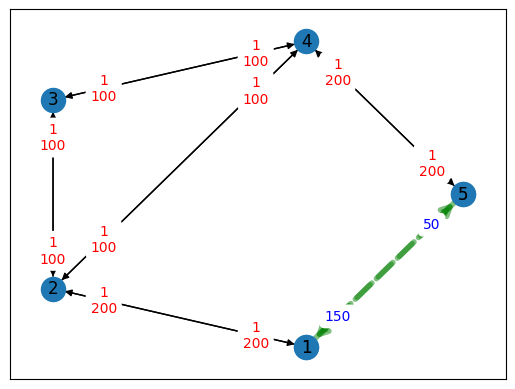

In [9]:
instance.draw(capacity_name="bandwidth")
plt.show()

In [10]:
# Reduce the size of the graph
from mcnf_ai.contraction import GraphContractor
exclude_nodes = demands[0,:2].tolist()
mcnf_contract, expander = GraphContractor().apply(instance)

(2, 4, 0) {'cost': 1, 'bandwidth': 100}
(2, 4, 1) {'cost': 2.0, 'bandwidth': 100, 'type': 'chain', 'chain': [(2, 3, 0), (3, 4, 0)]}
(4, 2, 0) {'cost': 1, 'bandwidth': 100}
(4, 2, 1) {'cost': 2.0, 'bandwidth': 100, 'type': 'chain', 'chain': [(4, 3, 0), (3, 2, 0)]}


<AxesSubplot:>

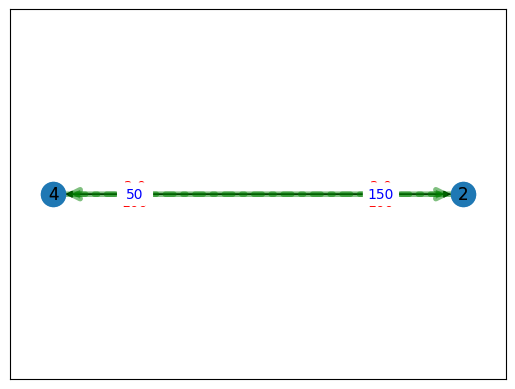

In [11]:
for e in mcnf_contract.G.edges:
    print(e, mcnf_contract.G.edges[e])
mcnf_contract.draw()

In [12]:
# solve the problem on the contracted graph
status_c, solution_c, solve_t = mcnf_contract.solve_with_cplex(capacity="bandwidth")
print(solution_c)
print(solution_c.shape)

[  0.  50.   0.   0. 100.   0.  50.   0.]
(8,)


In [13]:
# get the paths used on the contracted graph
paths_c, flows_c = mcnf_contract.solution_paths(solution_c)
for k,demand in enumerate(mcnf_contract.demands):
    print("demand", k, demand)
    for path,flow in zip(paths_c[k], flows_c[k]):
        print("\t",path,flow)

demand 0 [  4   2 150]
	 Path ([(4, 2, 0)]) 100.0
	 Path ([(4, 2, 1)]) 50.0
demand 1 [ 2  4 50]
	 Path ([(2, 4, 0)]) 50.0


In [14]:
# reconstruct the paths on the original graph
paths_r, flows_r = expander.apply(solution_c, mcnf_contract)
for k,demand in enumerate(instance.demands):
    print("demand", k, demand)
    for path,flow in zip(paths_r[k], flows_r[k]):
        print("\t",path,flow)
x_r = instance.paths_to_solution(paths_r, flows_r)
print(x_r)

demand 0 [  5   1 150]
	 Path ([(5, 4, 0), (4, 2, 0), (2, 1, 0)]) 100.0
	 Path ([(5, 4, 0), (4, 3, 0), (3, 2, 0), (2, 1, 0)]) 50.0
demand 1 [ 1  5 50]
	 Path ([(1, 2, 0), (2, 4, 0), (4, 5, 0)]) 50.0
[150.   0.  50.   0. 100.   0.   0.  50.  50.   0.   0.   0. 150.   0.
   0.   0.   0.  50.   0.  50.]


In [15]:
# solution of the original problem
status, sol, t = instance.solve_with_cplex(capacity="bandwidth")
paths_o, flows_o = instance.solution_paths(sol)
for k,demand in enumerate(demands):
    print(k, demand)
    for path,flow in zip(paths_o[k], flows_o[k]):
        print("\t",path,flow)
print(sol)

0 [  5   1 150]
	 Path ([(5, 4, 0), (4, 3, 0), (3, 2, 0), (2, 1, 0)]) 50.0
	 Path ([(5, 4, 0), (4, 2, 0), (2, 1, 0)]) 100.0
1 [ 1  5 50]
	 Path ([(1, 2, 0), (2, 4, 0), (4, 5, 0)]) 50.0
[150.   0.  50.   0. 100.   0.   0.  50.  50.   0.   0.   0. 150.   0.
   0.   0.   0.  50.   0.  50.]
